In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

/Users/yowtzu/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/yowtzu/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [3]:
gatrain = pd.read_csv('data/gender_age_train.csv')
gatest = pd.read_csv('data/gender_age_test.csv')
gatrain.head(3)

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38


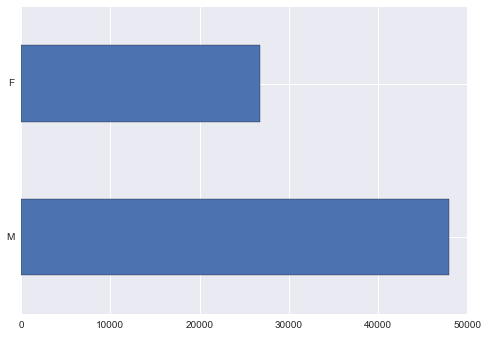

In [26]:
gatrain.gender.value_counts().plot(kind='barh')

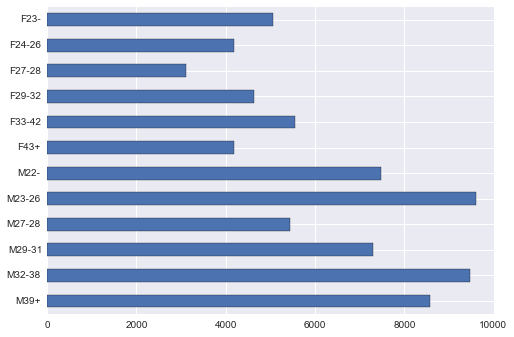

In [21]:
gatrain.group.value_counts().sort_index(ascending=False).plot(kind='barh')

In [51]:
gatrain.age.quantile?

In [75]:
gam = gatrain[gatrain.gender=='M']
gaf = gatrain[gatrain.gender=='F']

In [ ]:
print(gam.age[(gam.age>=0) & (gam.age<23)].count())
print(gam.age[(gam.age>=23) & (gam.age<27)].count())
print(gam.age[(gam.age>=27) & (gam.age<29)].count())
print(gam.age[(gam.age>=29) & (gam.age<32)].count())
print(gam.age[(gam.age>=32) & (gam.age<39)].count())
print(gam.age[gam.age>=39].count())

In [97]:
print(gam.age[(gam.age>=0) & (gam.age<23)].count())
print(gam.age[(gam.age>=23) & (gam.age<27)].count())
print(gam.age[(gam.age>=27) & (gam.age<29)].count())
print(gam.age[(gam.age>=29) & (gam.age<32)].count())
print(gam.age[(gam.age>=32) & (gam.age<39)].count())
print(gam.age[gam.age>=39].count())

7488
9605
5445
7309
9476
8581


In [ ]:
gatrain[gatrain.gender=='F'].age.quantile

/Users/yowtzu/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


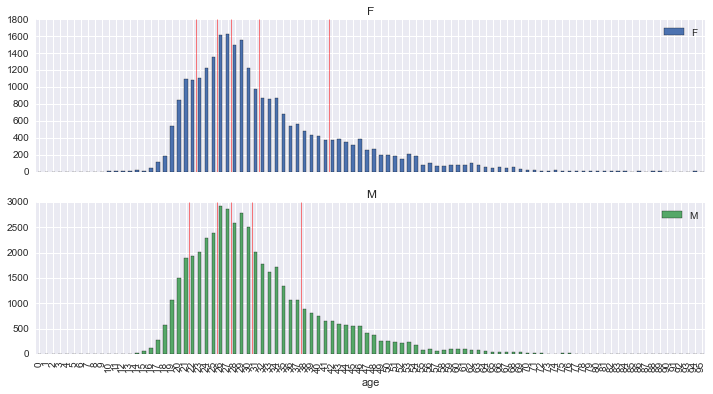

In [39]:
c = gatrain.groupby(['age', 'gender']).size().unstack().reindex(index=np.arange(96)).fillna(0)

ax1, ax2 = c.plot(kind='bar', figsize=(12,6), subplots=True)
ax1.vlines(np.array([23,26,28,32,42])-0.5,0,1800,alpha=0.5,linewidth=1,color='r')
ax2.vlines(np.array([22,26,28,31,38])-0.5,0,3000,alpha=0.5,linewidth=1,color='r')

### Benchmark 1/n classes

In [115]:
letarget = LabelEncoder().fit(gatrain.group.values)
y = letarget.transform(gatrain.group.values)
n_classes = len(letarget.classes_)

In [116]:
pred = np.ones((gatrain.shape[0],n_classes))/n_classes
log_loss(y, pred)

2.4849066497880012

### KFold

In [117]:
kf = KFold(gatrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((gatrain.shape[0],n_classes))
for itrain, itest in kf:
    train = gatrain.iloc[itrain,:]
    test = gatrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    prob = train.groupby('group').size()/train.shape[0]
    pred[itest,:] = prob.values
print(log_loss(y, pred))

2.42805122275


In [134]:
phone = pd.read_csv('data/phone_brand_device_model.csv',encoding='utf-8')
phone.head(3)
print('{} rows'.format(phone.shape[0]))
print("unique values:")
for c in phone.columns:
    print('{}: {}'.format(c, phone[c].nunique()))

187245 rows
unique values:
device_id: 186716
phone_brand: 131
device_model: 1599


In [137]:
c.sort_values()

device_model
1100           1
T820           1
T80            1
T780+          1
T730D          1
T730           1
T708           1
T703           1
T701           1
T7             1
T85+           1
T621           1
T619           1
T6             1
T55            1
T528w          1
T528t          1
T528d          1
T50            1
T35            1
T329t          1
T619+          1
T329d          1
T860           1
T87+           1
TAB A10-80     1
TAB 2 A7-30    1
T967           1
T9608          1
T9600          1
              ..
M8             2
A1             2
T60            2
U11            2
7060           2
X              2
E5             2
P1             2
E3             2
U2             2
K1             2
L810           2
V70            2
P9             2
Q7             2
L6             2
P8             2
D500           2
L7             2
S7             3
M3             3
T5             3
S3             3
M2             3
X5             3
N1             3
R1             3
X

In [142]:

lebrand = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = lebrand.transform(phone.phone_brand)
m = phone.phone_brand.str.cat(phone.device_model)
lemodel = LabelEncoder().fit(m)
phone['model'] = lemodel.transform(m)

In [143]:
phone

,device_id,phone_brand,device_model,brand,model
0,-8890648629457979026,小米,红米,51,858
1,1277779817574759137,小米,MI 2,51,843
2,5137427614288105724,三星,Galaxy S4,15,371
3,3669464369358936369,SUGAR,时尚手机,9,166
4,-5019277647504317457,三星,Galaxy Note 2,15,347
5,3238009352149731868,华为,Mate,31,671
6,-3883532755183027260,小米,MI 2S,51,846
7,-2972199645857147708,华为,G610S,31,648
8,-5827952925479472594,小米,MI One Plus,51,852
9,-8262508968076336275,vivo,S7I,13,214


In [1]:
import datetime
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import random
import zipfile
import time
import shutil
from sklearn.metrics import log_loss
from pygeocoder import Geocoder, GeocoderError
import pickle

/Users/yowtzu/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/yowtzu/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
events = pd.read_csv("data/events.csv", dtype={'device_id': np.str})
events = events.sort_values(['device_id','timestamp'])
events['timestamp'] = pd.to_datetime(events.timestamp)

### Create and save the latitude and longitude mapping

In [ ]:
#coord_to_loc_map = dict()

In [ ]:
#for row in events.itertuples():
#    key = (row.latitude, row.longitude)
#    if key not in coord_to_loc_map.keys():
#        try:
#            print(key)
#            coord_to_loc_map[key] = Geocoder.reverse_geocode(row.latitude, row.longitude)
#            time.sleep(1)
#        except GeocoderError as e:
#            coord_to_loc_map[key] = None

In [ ]:
#coord_to_loc_data_map = {k:v.data for k,v in coord_to_loc_map.items() if v}
#coord_to_loc_address_map = {k:v.formatted_address for k,v in coord_to_loc_map.items() if v}

#with open('data/coord_to_loc_data_map.pickle', 'wb') as handle:
#    pickle.dump(coord_to_loc_data_map, handle)
    
#with open('data/coord_to_loc_address_map.pickle', 'wb') as handle:
#    pickle.dump(coord_to_loc_address_map, handle)

In [3]:
with open('data/coord_to_loc_address_map.pickle', 'rb') as handle:
    coord_to_loc_address_map = pickle.load(handle)

In [4]:
res = list()
for k,v in coord_to_loc_address_map.items():
    if v:
        country = None
        route = None
        qu = None
        shi = None
        sheng = None
        location = list(v.upper().split(', '))
        if(len(location) <= 3):
            country = "OTHER"
        else:
            for item in location[::-1]:
                if item=='CHINA':
                    country = item
                if item.endswith('DAO') or item.endswith('LU') or item.endswith('JIE') or item.endswith('ROAD'):
                    route = item
                elif item.endswith('QU') or item.endswith('XIAN'):
                    qu = item
                elif item.endswith('SHI'):
                    shi = item
                elif item.endswith('SHENG'):
                    sheng = item
        item = np.array([k[0], k[1], route, qu, shi, sheng, country])
        res.append(item)
address = pd.DataFrame(res, columns=['latitude', 'longitude', 'route', 'qu', 'shi', 'sheng', 'country'])
address.latitude = address.latitude.astype('float')
address.longitude = address.longitude.astype('float')

In [5]:
import math
from collections import namedtuple

def haversine_distance(origin, destination):
      """ Haversine formula to calculate the distance between two lat/long points on a sphere """

      radius = 6371 # FAA approved globe radius in km

      dlat = math.radians(destination[0]-origin[0])
      dlon = math.radians(destination[1]-origin[1])
      a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(origin[0])) \
          * math.cos(math.radians(destination[0])) * math.sin(dlon/2) * math.sin(dlon/2)
      c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
      d = radius * c

      # Return distance in km
      return d

LatLng = namedtuple('LatLng', 'lat, lng')
  
origin = (51.3, -0.1275) # London
destination = (37.966667, 23.716667) # Athens

haversine_distance(origin, destination)

2381.0141034018447

In [6]:
events = events.sort_values(['device_id','timestamp'])

events.ix[events.longitude==0, 'longitude']=np.nan
events.ix[events.latitude==0, 'latitude']=np.nan
events['longitude'] = events.groupby(['device_id'])['longitude'].fillna(method='ffill').fillna(method='backfill')
events['latitude'] = events.groupby(['device_id'])['latitude'].fillna(method='ffill').fillna(method='backfill')

events["min_latitude"] = events.groupby('device_id')["latitude"].transform(min)
events["max_latitude"] = events.groupby('device_id')["latitude"].transform(max)
events["min_longitude"] = events.groupby('device_id')["longitude"].transform(min)
events["max_longitude"] = events.groupby('device_id')["longitude"].transform(max)

events['longitude'] = events.groupby(['device_id'])['longitude'].transform(np.median)
# should use mode and find out the distance travels instead
events['latitude'] = events.groupby(['device_id'])['latitude'].transform(np.median)

In [7]:
unique_location = events[["min_latitude", "max_latitude", "min_longitude", "max_longitude"]].drop_duplicates()
unique_location["distance"] = unique_location.apply(
    lambda row: haversine_distance((row.min_latitude, row.min_longitude), (row.max_latitude, row.max_longitude)), axis=1)

In [8]:
events["hour"] = pd.DatetimeIndex(events.timestamp).hour
events["day_or_night"] = 'day'
events.ix[events.hour >=23 | (events.hour <= 7) , "day_or_night"] = 'night'
events.drop('hour', axis=1, inplace=True)

tmp = pd.DataFrame(events.groupby('device_id').apply(lambda x: np.log(1+len(x))).rename('counts'))
events = events.join(tmp, on=['device_id'])

tmp = pd.DataFrame(events.ix[events.day_or_night=='day',:].groupby('device_id').apply(lambda x: np.log(1+len(x))).rename('day_counts'))
events = events.join(tmp, on=['device_id'])

tmp = pd.DataFrame(events.ix[events.day_or_night=='night',:].groupby('device_id').apply(lambda x: np.log(1+len(x))).rename('night_counts'))
events = events.join(tmp, on=['device_id'])
events.drop(['day_or_night', 'timestamp'], axis=1, inplace=True)
events = events.drop_duplicates()

In [9]:
events["day_counts"] = events["day_counts"].fillna(np.log(1))
events["night_counts"] = events["night_counts"].fillna(np.log(1))

In [10]:
events = events.merge(unique_location, how='left')

In [11]:
events = events.merge(address, how='left')

In [12]:
random.seed(2016)

def run_xgb(train, test, features, target, random_state=0):
    eta = 0.05
    max_depth = 7
    subsample = 0.7
    colsample_bytree = 0.7
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "multi:softprob",
        "num_class": 12,
        "booster" : "gbtree",
        "eval_metric": "mlogloss",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state,
    }
    num_boost_round = 500
    early_stopping_rounds = 50
    test_size = 0.3

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    print('Length train:', len(X_train.index))
    print('Length valid:', len(X_valid.index))
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration)
    score = log_loss(y_valid.tolist(), check)

    print("Predict test set...")
    test_prediction = gbm.predict(xgb.DMatrix(test[features]), ntree_limit=gbm.best_iteration)

    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    return test_prediction.tolist(), score


def create_submission(score, test, prediction):
    # Make Submission
    now = datetime.datetime.now()
    sub_file = 'submission_' + str(score) + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print('Writing submission: ', sub_file)
    f = open(sub_file, 'w')
    f.write('device_id,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+\n')
    total = 0
    test_val = test['device_id'].values
    for i in range(len(test_val)):
        str1 = str(test_val[i])
        for j in range(12):
            str1 += ',' + str(prediction[i][j])
        str1 += '\n'
        total += 1
        f.write(str1)
    f.close()


def map_column(table, f):
    labels = sorted(table[f].unique())
    mappings = dict()
    for i in range(len(labels)):
        mappings[labels[i]] = i
    table = table.replace({f: mappings})
    return table


def read_train_test():
    # Events
    print('Read events...')
    events = pd.read_csv("input/events.csv", dtype={'device_id': np.str})
    events['counts'] = events.groupby(['device_id'])['event_id'].transform('count')
    events_small = events[['device_id', 'counts']].drop_duplicates('device_id', keep='first')

    # Phone brand
    print('Read brands...')
    pbd = pd.read_csv("input/phone_brand_device_model.csv", dtype={'device_id': np.str})
    pbd.drop_duplicates('device_id', keep='first', inplace=True)
    pbd = map_column(pbd, 'phone_brand')
    pbd = map_column(pbd, 'device_model')

    # Train
    print('Read train...')
    train = pd.read_csv("input/gender_age_train.csv", dtype={'device_id': np.str})
    train = map_column(train, 'group')
    train = train.drop(['age'], axis=1)
    train = train.drop(['gender'], axis=1)
    train = pd.merge(train, pbd, how='left', on='device_id', left_index=True)
    train = pd.merge(train, events_small, how='left', on='device_id', left_index=True)
    train.fillna(-1, inplace=True)

    # Test
    print('Read test...')
    test = pd.read_csv("input/gender_age_test.csv", dtype={'device_id': np.str})
    test = pd.merge(test, pbd, how='left', on='device_id', left_index=True)
    test = pd.merge(test, events_small, how='left', on='device_id', left_index=True)
    test.fillna(-1, inplace=True)

    # Features
    features = list(test.columns.values)
    features.remove('device_id')

    return train, test, features



In [13]:
#train, test, features = read_train_test()
#print('Length of train: ', len(train))
#print('Length of test: ', len(test))
#print('Features [{}]: {}'.format(len(features), sorted(features)))

In [14]:
app = pd.read_csv("data/app_events.csv", dtype={'app_id': np.str}).drop_duplicates()
app_labels = pd.read_csv('data/app_labels.csv',  dtype={'app_id': np.str}).drop_duplicates()
labels_categories = pd.read_csv('data/label_categories.csv').drop_duplicates()
app_labels = pd.merge(app_labels, labels_categories, how='left', on='label_id')
app = pd.merge(app, app_labels, how='left', on='app_id')
app.drop(['is_installed', 'is_active', 'label_id'], axis=1, inplace=True)

In [ ]:
events = pd.merge(events, app, how='left')

In [ ]:
events['app_count'] = events.groupby('device_id')['app_id'].transform('count')
events['app_category_count'] = events.groupby('device_id')['category'].transform('count')

In [ ]:
events_small = events.drop(['event_id', 'app_id', 'category'], axis=1).drop_duplicates()

In [ ]:
events_small["country"] = events_small.apply(lambda x: 0 if x["country"]=='China' else 1, axis=1)

In [ ]:
events_small.ix[pd.isnull(events_small.shi),"shi"] = 'Unknown'
events_small.ix[pd.isnull(events_small.sheng), 'sheng'] = 'Unknown'
events_small.ix[pd.isnull(events_small.qu), 'qu'] = 'Unknown'
events_small.ix[pd.isnull(events_small.route), 'route'] = 'Unknown'

In [ ]:
events_small.shi = events_small.shi.astype('str')
events_small.sheng = events_small.sheng.astype('str')
events_small.qu = events_small.qu.astype('str')
events_small.route = events_small.route.astype('str')

In [ ]:
events_small = map_column(events_small, 'shi')
events_small = map_column(events_small, 'sheng')
events_small = map_column(events_small, 'qu')
events_small = map_column(events_small, 'route')

In [ ]:
#events_small.drop(['min_latitude', 'max_latitude', 'min_longitude', 'max_longitude'], axis=1, inplace=True)

In [ ]:
# Phone brand
print('Read brands...')
pbd = pd.read_csv("data/phone_brand_device_model.csv", dtype={'device_id': np.str})
pbd.drop_duplicates('device_id', keep='first', inplace=True)
pbd = map_column(pbd, 'phone_brand')
pbd = map_column(pbd, 'device_model')

In [ ]:
# Train

print('Read train...')
train = pd.read_csv("data/gender_age_train.csv", dtype={'device_id': np.str})
train = map_column(train, 'group')
train = train.drop(['age'], axis=1)
train = train.drop(['gender'], axis=1)
train = pd.merge(train, pbd, how='left', on='device_id', left_index=True)
train = pd.merge(train, events_small, how='left', on='device_id', left_index=True)


In [ ]:
# Test
print('Read test...')
test = pd.read_csv("data/gender_age_test.csv", dtype={'device_id': np.str})
test = pd.merge(test, pbd, how='left', on='device_id', left_index=True)
test = pd.merge(test, events_small, how='left', on='device_id', left_index=True)

In [ ]:
# Features
features = list(test.columns.values)
features.remove('device_id')

In [ ]:
test_prediction, score = run_xgb(train, test, features, 'group')
print("LS: {}".format(round(score, 5)))

In [ ]:
create_submission(score, test, test_prediction)